In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [637]:
def convert_to_df_and_model(train_df, test_df, estimator):
    
    #make the values of the properties with a value of 0 == 1. Then we can take the log transform of the av_total.
    for i in range(len(train_df)):
        if train_df.AV_TOTAL[i] == 0:
            train_df.set_value(i, 'AV_TOTAL', 1)
        else:
            continue
    #again we've made where the target variable is 0 and update it to 1, for the purpose of performing a log transofrm
    for i in range(len(train_df)):
        if train_df.GROSS_TAX[i] == 0:
            train_df.set_value(i, 'GROSS_TAX', 1)
        else:
            continue
    #again we've made where the target variable is 0 and update it to 1, for the purpose of performing a log transofrm        
    for i in range(len(train_df)):
        if train_df.AV_LAND[i] == 0:
            train_df.set_value(i, 'AV_LAND', 1)
        else:
            continue
    #again we've made where the target variable is 0 and update it to 1, for the purpose of performing a log transofrm
    for i in range(len(train_df)):
        if train_df.AV_BLDG[i] == 0:
            train_df.set_value(i, 'AV_BLDG', 1)
        else:
            continue
    
    #Filter the DataFrame for the outliers, we'll take the 95% percentile to train our model on.        
    train_df_ = train_df[train_df['AV_TOTAL']<np.percentile(train_df['AV_TOTAL'], 99)]
    
    #depending on what you're trying to predict at you may want to use one of these instead!
    #train_df_ = train_df[train_df['GROSS_TAX']<np.percentile(train_df['GROSS_TAX'], 95)]
    #train_df_ = train_df[train_df['AV_LAND']<np.percentile(train_df['AV_LAND'], 95)]
    #train_df_ = train_df[train_df['AV_BLDG']<np.percentile(train_df['AV_BLDG'], 95)]
            
    #Make the target into a log transform
    train_df_.AV_TOTAL = np.log(train_df_.AV_TOTAL)
    
    #depending on what you're predicting you might want to add in the log transofrm of one of these too!
    #train_df_.GROSS_TAX = np.log(train_df_.GROSS_TAX)
    #train_df_.AV_LAND = np.log(train_df_.AV_LAND)
    #train_df_.AV_BLDG = np.log(train_df_.AV_BLDG)
    
    
    #Re-assinging the dataframe to another variable for naming purposes.
    df_train = train_df_
    df_test = test_df
    
    
    #Feature Engineering on Training Set
    #we'll take features that are either categorical and dummie them or numerical and eventually scale them.
    categorical_features = df_train.select_dtypes(include = ['object']).columns
    df_train_categorical = df_train[categorical_features]
    df_train_categorical['PTYPE'] = df_train['PTYPE']
    df_train_categorical['YR_BUILT'] = df_train['YR_BUILT']
    df_train_categorical['YR_REMOD'] = df_train['YR_REMOD']
    df_train_categorical['ZIPCODE'] = df_train['ZIPCODE']
    categoricals_to_drop = ['PID','OWNER','ST_NUM','ST_NAME','ST_NAME_SUF','UNIT_NUM',
                            'MAIL_ADDRESS','MAIL CS','MAIL_ZIPCODE', 'LatLong', 'GIS_ID']
    df_train_categorical.drop(categoricals_to_drop, axis = 1, inplace=True) #dropping the categorical variables that we don't need
    df_train_dummied = pd.get_dummies(df_train_categorical) #dummie-ing the categorical variables
    
    numeric_features = df_train.select_dtypes(include = ['float64', 'int64']).columns #selecting the 'numeric' features
    df_train_numeric = df_train[numeric_features]
    numeric_drop_list = ['ZIPCODE','GROSS_TAX','AV_TOTAL','AV_LAND', 'AV_BLDG','PTYPE','YR_REMOD','YR_BUILT'] #None of these are actually 'numerical' features
    df_train_numeric.drop(numeric_drop_list, axis = 1, inplace = True)
    
    
    #Feature Engineering on Testing Set
    # Here we'll take the exact same approach to the testing dataframe.
    #take the categorical variables, add in the other true categorical variables like zip code and ptype
    #drop the features we don't need
    categorical_features = df_test.select_dtypes(include = ['object']).columns
    df_test_categorical = df_test[categorical_features]
    df_test_categorical['PTYPE'] = df_test['PTYPE']
    df_test_categorical['YR_BUILT'] = df_test['YR_BUILT']
    df_test_categorical['YR_REMOD'] = df_test['YR_REMOD']
    df_test_categorical['ZIPCODE'] = df_test['ZIPCODE']
    categoricals_to_drop = ['PID','OWNER','ST_NUM','ST_NAME','ST_NAME_SUF','UNIT_NUM',
                            'MAIL_ADDRESS','MAIL CS','LatLong', 'GIS_ID']
    df_test_categorical.drop(categoricals_to_drop, axis = 1, inplace=True)
    df_test_dummied = pd.get_dummies(df_test_categorical)
    
    numeric_features = df_test.select_dtypes(include = ['float64', 'int64']).columns
    df_test_numeric = df_test[numeric_features]
    numeric_drop_list = ['ZIPCODE','PTYPE','YR_REMOD','YR_BUILT'] #None of these are actually 'numerical' features
    df_test_numeric.drop(numeric_drop_list, axis = 1, inplace = True)
    
    # Now, we concatenate the categorical and dummied variables back together for both training and testing dataframes
    X_testing_set = pd.concat([df_test_numeric, df_test_dummied], axis = 1)
    X_training_set = pd.concat([df_train_numeric, df_train_dummied], axis = 1)
    
    #must drop columns that are not present in both engineered dataframes now
    last_training_drop = []
    for i in X_training_set.columns:
        if i not in X_testing_set.columns:
            last_training_drop.append(i)
    X_training_set.drop(last_training_drop, axis = 1, inplace = True)
            
    last_testing_drop = []
    for i in X_testing_set.columns:
        if i not in X_training_set.columns:
            last_testing_drop.append(i)
    X_testing_set.drop(last_testing_drop, axis = 1, inplace = True)
        
    
    # Here we assign our feature matrix and specified target variables.
    X = X_training_set
    y_total = df_train['AV_TOTAL']
    y_tax = df_train['GROSS_TAX']
    y_land = df_train['AV_LAND']
    y_bldg = df_train['AV_BLDG']
    
    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y_total,
                                                        train_size = 0.85,
                                                        random_state = 42)

    #Scale Data
    ss = StandardScaler()
    ss.fit(X_training_set)
    X_train_ss = ss.transform(X_train)
    X_test_ss = ss.transform(X_test)
    
#    print('First, let\'s look at the data')
#    plt.figure(figsize=(10,6))
#    sns.distplot(np.log(train_df[train_df['AV_TOTAL']>0]['AV_TOTAL']))
#    plt.title('Assessed Tax Value')
#    plt.xlabel('log(AV_TOTAL)');
    
#    plt.figure(figsize=(10,6))
#    sns.distplot(np.log(train_df[train_df['GROSS_TAX']>0]['GROSS_TAX']))
#    plt.title('GROSS_TAX')
#    plt.xlabel('log(GROSS_TAX)');
    
#    plt.figure(figsize=(10,6))
#    sns.distplot(np.log(i[i['AV_LAND']>0]['AV_LAND']))
#    plt.title('AV_LAND')
#    plt.xlabel('log(AV_LAND)');
    
#    plt.figure(figsize=(10,6))
#    sns.distplot(np.log(i[i['AV_BLDG']>0]['AV_BLDG']))
#    plt.title('AV_BLDG')
#    plt.xlabel('log(AV_BLDG)');

    X_test.reset_index(drop = True, inplace = True)

    def gsoptimizer(est, params):
        gs = GridSearchCV(est, param_grid = params, verbose=0, scoring = 'neg_mean_squared_error') #scoring='r2')
        gs.fit(X_train_ss, y_train)
#        print("Your best R^2 score is:",gs.best_score_)
        print("Your best RMSE score is",np.sqrt(gs.best_score_*-1))
        print("But the actual RMSE score will be something like: ", np.exp(np.sqrt(gs.best_score_*-1)))
        print("Your best alpha value is:",gs.best_params_)
        y_pred = gs.predict(X_test_ss)
        
        y_pred_df = pd.DataFrame(y_pred)

        for i in X_test.index:
            if X_test.LU_CM[i] == 1:
                y_pred_df.set_value(i, 0, 0)

        x = np.linspace(0, max(y_pred), 1000)
        plt.figure(figsize=(8,8))
        plt.title('Log Transform of AV_TOTAL, True Target 2018 vs Predicted Target 2018')
        plt.scatter(y_pred_df[0],y_test, color = 'r')
        plt.plot(x,x, color = 'black')
        plt.xlabel('log(Predicted Values)')
        plt.ylabel('log(True Values)')
        plt.xlim(0,max(y_pred))
        
        #Standard Scale the X_testing_set
        ss_ = StandardScaler()
        ss_.fit(X_training_set)
        X_testing_set_ss = ss_.transform(X_testing_set)
        test_df_predictions = gs.predict(X_testing_set_ss)

        solution = pd.DataFrame({"PID":test_df.PID, 
                                 "AV_TOTAL_preds":test_df_predictions}, 
                                columns=['PID', 'AV_TOTAL_preds'])

        #convert out of log format
        solution.AV_TOTAL_preds = np.exp(solution.AV_TOTAL_preds)
        solution.to_csv("AV_TOTAL_test_predictions.csv", index = False)

        return gs.best_estimator_, gs.best_score_, y_pred
                 
    #Ridge Regression
    ridgeParams = {'alpha':[0.01, 0.1, 1, 10, 100, 1000, 10000]}
    bestRidgeEst = gsoptimizer(estimator(), ridgeParams)


In [75]:
train_2008 = pd.read_csv('./train_clean/train_clean_2008.csv')
test_2008 = pd.read_csv('./test_clean/test_clean_2008.csv')
train_2009 = pd.read_csv('./train_clean/train_clean_2009.csv')
test_2009 = pd.read_csv('./test_clean/test_clean_2009.csv')
train_2010 = pd.read_csv('./train_clean/train_clean_2010.csv')
test_2010 = pd.read_csv('./test_clean/test_clean_2010.csv')
train_2011 = pd.read_csv('./train_clean/train_clean_2011.csv')
test_2011 = pd.read_csv('./test_clean/test_clean_2011.csv')
train_2012 = pd.read_csv('./train_clean/train_clean_2012.csv')
test_2012 = pd.read_csv('./test_clean/test_clean_2012.csv')
train_2013 = pd.read_csv('./train_clean/train_clean_2010.csv')
test_2013 = pd.read_csv('./test_clean/test_clean_2010.csv')
train_2014 = pd.read_csv('./train_clean/train_clean_2014.csv')
test_2014 = pd.read_csv('./test_clean/test_clean_2014.csv')
train_2015 = pd.read_csv('./train_clean/train_clean_2015.csv')
test_2015 = pd.read_csv('./test_clean/test_clean_2015.csv')
train_2016 = pd.read_csv('./train_clean/train_clean_2016.csv')
test_2016 = pd.read_csv('./test_clean/test_clean_2016.csv')
train_2017 = pd.read_csv('./train_clean/train_clean_2017.csv')
test_2017 = pd.read_csv('./test_clean/test_clean_2017.csv')
train_2018 = pd.read_csv('./train_clean/train_clean_2018.csv')
test_2018 = pd.read_csv('./test_clean/test_clean_2018.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (12,23,24,25,31,35,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (12,31,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

Your best RMSE score is 0.6117033851674073
But the actual RMSE score will be something like:  1.8435690338698283
Your best alpha value is: {'alpha': 0.01}


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:162: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


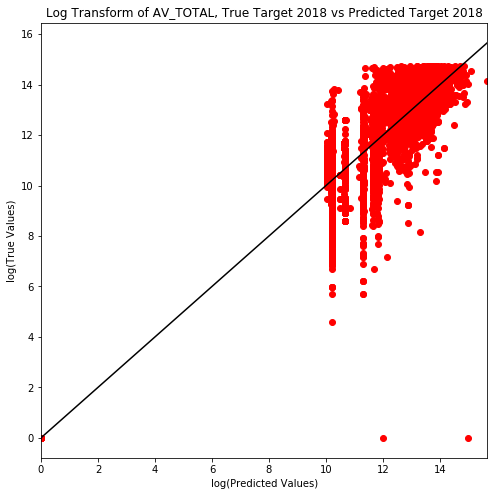

In [636]:
convert_to_df_and_model(train_2018, test_2018, Ridge)

# Neural Network For Regression

In [672]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:923: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [673]:
train_2018 = pd.read_csv('./train_clean/train_clean_2018.csv')
test_2018 = pd.read_csv('./test_clean/test_clean_2018.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [676]:
#make the values of the properties with a value of 0 == 1. Then we can take the log transform of the price.
for i in range(len(train_2018)):
    if train_2018.AV_TOTAL[i] == 0:
        train_2018.set_value(i, 'AV_TOTAL', 1)
    else:
        continue
#            train_df_.set_value(i, 'AV_TOTAL', train_df_['AV_TOTAL'][i])

#Filter the DataFrame for the outliers        
train_df_ = train_2008[train_2008['AV_TOTAL']<np.percentile(train_2008['AV_TOTAL'], 95)]

#Make the target into a log transform
train_df_.AV_TOTAL = np.log(train_df_.AV_TOTAL)

df_train = train_df_
df_test = test_2018


#Feature Engineering on Training Set
categorical_features = df_train.select_dtypes(include = ['object']).columns
df_train_categorical = df_train[categorical_features]
df_train_categorical['PTYPE'] = df_train['PTYPE']
df_train_categorical['YR_BUILT'] = df_train['YR_BUILT']
df_train_categorical['YR_REMOD'] = df_train['YR_REMOD']
df_train_categorical['ZIPCODE'] = df_train['ZIPCODE']
categoricals_to_drop = ['PID','OWNER','ST_NUM','ST_NAME','ST_NAME_SUF','UNIT_NUM',
                        'MAIL_ADDRESS','MAIL CS','MAIL_ZIPCODE', 'LatLong', 'GIS_ID']
df_train_categorical.drop(categoricals_to_drop, axis = 1, inplace=True)
df_train_dummied = pd.get_dummies(df_train_categorical)

numeric_features = df_train.select_dtypes(include = ['float64', 'int64']).columns
df_train_numeric = df_train[numeric_features]
numeric_drop_list = ['ZIPCODE','GROSS_TAX','AV_TOTAL','AV_LAND', 'AV_BLDG','PTYPE','YR_REMOD','YR_BUILT']
df_train_numeric.drop(numeric_drop_list, axis = 1, inplace = True)


#Feature Engineering on Testing Set
categorical_features = df_test.select_dtypes(include = ['object']).columns
df_test_categorical = df_test[categorical_features]
df_test_categorical['PTYPE'] = df_test['PTYPE']
df_test_categorical['YR_BUILT'] = df_test['YR_BUILT']
df_test_categorical['YR_REMOD'] = df_test['YR_REMOD']
df_test_categorical['ZIPCODE'] = df_test['ZIPCODE']
categoricals_to_drop = ['PID','OWNER','ST_NUM','ST_NAME','ST_NAME_SUF','UNIT_NUM',
                        'MAIL_ADDRESS','MAIL CS', 'LatLong', 'GIS_ID']
df_test_categorical.drop(categoricals_to_drop, axis = 1, inplace=True)
df_test_dummied = pd.get_dummies(df_test_categorical)

numeric_features = df_test.select_dtypes(include = ['float64', 'int64']).columns
df_test_numeric = df_test[numeric_features]
numeric_drop_list = ['ZIPCODE','PTYPE','YR_REMOD','YR_BUILT']
df_test_numeric.drop(numeric_drop_list, axis = 1, inplace = True)

#y_testing = df_test['AV_TOTAL']


X_testing_set = pd.concat([df_test_numeric, df_test_dummied], axis = 1)
X_training_set = pd.concat([df_train_numeric, df_train_dummied], axis = 1)
X = X_training_set
y = df_train['AV_TOTAL']
y_tax = df_train['GROSS_TAX']
y_land = df_train['AV_LAND']
y_bldg = df_train['AV_BLDG'];

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [677]:
# split into input (X) and output (Y) variables
X = X
Y = y

In [679]:
len(X.columns)

149

In [680]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(149, input_dim=149, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [686]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn = baseline_model, epochs = 5, batch_size = 32, verbose = 1)

In [687]:
kfold = KFold(n_splits=3, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/5
75826/75826 [==============================] - 5s 68us/step - loss: 251715.3392
Epoch 2/5
75826/75826 [==============================] - 5s 63us/step - loss: 257644.7909
Epoch 3/5
75826/75826 [==============================] - 5s 64us/step - loss: 1654470.8141
Epoch 4/5
75826/75826 [==============================] - 5s 63us/step - loss: 3197278.4573
Epoch 5/5
37913/37913 [==============================] - 1s 24us/step
Epoch 1/5
75826/75826 [==============================] - 5s 66us/step - loss: 397329.4686
Epoch 2/5
75826/75826 [==============================] - 5s 69us/step - loss: 130235.2105
Epoch 3/5
75826/75826 [==============================] - 4s 56us/step - loss: 718944.3524
Epoch 4/5
75826/75826 [==============================] - 4s 53us/step - loss: 48146367.5173
Epoch 5/5
37913/37913 [==============================] - 1s 21us/step
Epoch 1/5
75826/75826 [==============================] - 5s 62us/step - loss: 4688.4447
Epoch 2/5
75826/75826 [=========================

In [692]:
# evaluate model with standardized dataset
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=3, batch_size=5, verbose=1)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=2, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/3
56869/56869 [==============================] - 22s 386us/step - loss: 2.0065
Epoch 2/3
56869/56869 [==============================] - 20s 346us/step - loss: 0.4103
Epoch 3/3
56870/56870 [==============================] - 9s 156us/step
Epoch 1/3
56870/56870 [==============================] - 23s 401us/step - loss: 1.4317
Epoch 2/3
56870/56870 [==============================] - 21s 366us/step - loss: 0.4189
Epoch 3/3
56869/56869 [==============================] - 9s 151us/step
Standardized: -17.81 (17.42) MSE


In [693]:
# define the model
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(149, input_dim=149, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [697]:
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=20, batch_size=8, verbose=1)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=2, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/20
56869/56869 [==============================] - 21s 361us/step - loss: 1.6467
Epoch 2/20
56869/56869 [==============================] - 19s 330us/step - loss: 0.4125
Epoch 3/20
56869/56869 [==============================] - 19s 339us/step - loss: 0.3529
Epoch 4/20
56869/56869 [==============================] - 19s 333us/step - loss: 0.2701
Epoch 5/20
56869/56869 [==============================] - 19s 334us/step - loss: 0.2586
Epoch 6/20
56869/56869 [==============================] - 19s 336us/step - loss: 0.2676
Epoch 7/20
56869/56869 [==============================] - 19s 338us/step - loss: 0.2413
Epoch 8/20
56869/56869 [==============================] - 19s 332us/step - loss: 0.2335
Epoch 9/20
56869/56869 [==============================] - 19s 336us/step - loss: 0.2397
Epoch 10/20
56869/56869 [==============================] - 19s 338us/step - loss: 0.3417
Epoch 11/20
56869/56869 [==============================] - 20s 346us/step - loss: 0.2281
Epoch 12/20
56869/56869 [=====

In [699]:
results

array([-3.14187, -0.2766 ])

In [698]:
#model.predict(X_training_set)

# Clustering to Look at Property Clusters Over Time

In [130]:
from sklearn.cluster import KMeans 

We'll just re-run the function to take a look at the clustering of the dataset and take out the local variables that are stored in the function.

In [139]:
#make the values of the properties with a value of 0 == 1. Then we can take the log transform of the price.
for i in range(len(train_2008)):
    if train_2008.AV_TOTAL[i] == 0:
        train_2008.set_value(i, 'AV_TOTAL', 1)
    else:
        continue
#            train_df_.set_value(i, 'AV_TOTAL', train_df_['AV_TOTAL'][i])

#Filter the DataFrame for the outliers        
train_df_ = train_2008[train_2008['AV_TOTAL']<np.percentile(train_2008['AV_TOTAL'], 95)]

#Make the target into a log transform
train_df_.AV_TOTAL = np.log(train_df_.AV_TOTAL)

df_train = train_df_
df_test = test_2008


#Feature Engineering on Training Set
categorical_features = df_train.select_dtypes(include = ['object']).columns
df_train_categorical = df_train[categorical_features]
df_train_categorical['PTYPE'] = df_train['PTYPE']
df_train_categorical['YR_BUILT'] = df_train['YR_BUILT']
df_train_categorical['YR_REMOD'] = df_train['YR_REMOD']
df_train_categorical['ZIPCODE'] = df_train['ZIPCODE']
categoricals_to_drop = ['PID','OWNER','ST_NUM','ST_NAME','ST_NAME_SUF','UNIT_NUM',
                        'MAIL_ADDRESS','MAIL CS','MAIL_ZIPCODE', 'LatLong', 'GIS_ID']
df_train_categorical.drop(categoricals_to_drop, axis = 1, inplace=True)
df_train_dummied = pd.get_dummies(df_train_categorical)

numeric_features = df_train.select_dtypes(include = ['float64', 'int64']).columns
df_train_numeric = df_train[numeric_features]
numeric_drop_list = ['ZIPCODE','GROSS_TAX','AV_TOTAL','AV_LAND', 'AV_BLDG','PTYPE','YR_REMOD','YR_BUILT']
df_train_numeric.drop(numeric_drop_list, axis = 1, inplace = True)


#Feature Engineering on Testing Set
categorical_features = df_test.select_dtypes(include = ['object']).columns
df_test_categorical = df_test[categorical_features]
df_test_categorical['PTYPE'] = df_test['PTYPE']
df_test_categorical['YR_BUILT'] = df_test['YR_BUILT']
df_test_categorical['YR_REMOD'] = df_test['YR_REMOD']
df_test_categorical['ZIPCODE'] = df_test['ZIPCODE']
categoricals_to_drop = ['PID','OWNER','ST_NUM','ST_NAME','ST_NAME_SUF','UNIT_NUM',
                        'MAIL_ADDRESS','MAIL CS', 'LatLong', 'GIS_ID']
df_test_categorical.drop(categoricals_to_drop, axis = 1, inplace=True)
df_test_dummied = pd.get_dummies(df_test_categorical)

numeric_features = df_test.select_dtypes(include = ['float64', 'int64']).columns
df_test_numeric = df_test[numeric_features]
numeric_drop_list = ['ZIPCODE','PTYPE','YR_REMOD','YR_BUILT']
df_test_numeric.drop(numeric_drop_list, axis = 1, inplace = True)

#y_testing = df_test['AV_TOTAL']


X_testing_set = pd.concat([df_test_numeric, df_test_dummied], axis = 1)
X_training_set = pd.concat([df_train_numeric, df_train_dummied], axis = 1)
X = X_training_set
y_total = df_train['AV_TOTAL']
y_tax = df_train['GROSS_TAX']
y_land = df_train['AV_LAND']
y_bldg = df_train['AV_BLDG']

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [144]:
Sum_of_squared_distances = []
K = range(1,5)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

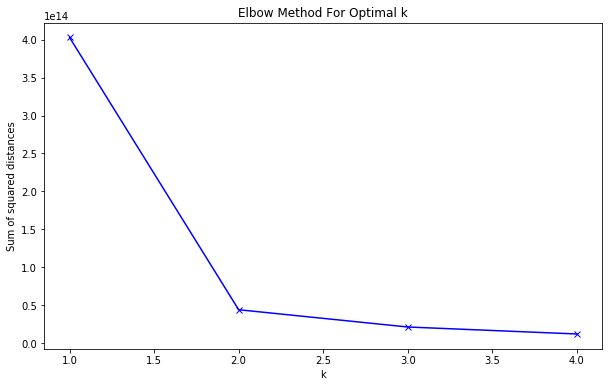

In [314]:
plt.figure(figsize=(10,6))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Thus the number where we begin to see deminishing returns in the sum of squared distances is where $k = 2$. However, this does not give us balanced clusters. For this reason, I bumped up the number of clusters to 15 to get an even balance of clusters so then I'm not comparing two clusters that have populations 110,000 and 100 respectively.

In [154]:
km = KMeans(n_clusters=15)
km_ = km.fit(X)
X['Predictions'] = km_.predict(X)

In [155]:
X.Predictions.value_counts()

10    59966
0     25485
11    21874
13     4712
5       795
8       460
12      260
4       121
9        41
3        19
14        2
7         1
6         1
2         1
1         1
Name: Predictions, dtype: int64

In this case we can look at clusters 10,0,11,3.

In [163]:
X['AV_TOTAL'] = y_total #adding back in the target to track it over time.
X['PID'] = train_2008['PID'] #add back in the PID columns so we can merge on it

Filter out the data frame for just the desired clusters.

In [164]:
cluster_10 = X[X.Predictions == 10] #filtering the X dataframe frame for the cluster 10
cluster_0 = X[X.Predictions == 0] #filtering the X dataframe frame for the cluster 0
cluster_11 = X[X.Predictions == 11] #filtering the X dataframe frame for the cluster 11
cluster_13 = X[X.Predictions == 13] #filtering the X dataframe frame for the cluster 13

Merging the prices onto the dataframe for cluster 10

In [170]:
merge_1 = pd.merge(cluster_10, train_2009[['PID','AV_TOTAL']], on = 'PID') 
merge_1.rename({'AV_TOTAL_x': 'AV_TOTAL_2008','AV_TOTAL_y': 'AV_TOTAL_2009'},inplace = True, axis = 1)
merge_2 = pd.merge(merge_1, train_2010[['PID','AV_TOTAL']], on = 'PID') 
merge_2.rename({'AV_TOTAL': 'AV_TOTAL_2010'},inplace = True, axis = 1)
merge_3 = pd.merge(merge_2, train_2011[['PID','AV_TOTAL']], on = 'PID')
merge_3.rename({'AV_TOTAL': 'AV_TOTAL_2011'},inplace = True, axis = 1)
merge_4 = pd.merge(merge_3, train_2012[['PID','AV_TOTAL']], on = 'PID') 
merge_4.rename({'AV_TOTAL': 'AV_TOTAL_2012'},inplace = True, axis = 1)
merge_5 = pd.merge(merge_4, train_2013[['PID','AV_TOTAL']], on = 'PID') 
merge_5.rename({'AV_TOTAL': 'AV_TOTAL_2013'},inplace = True, axis = 1)
merge_6 = pd.merge(merge_5, train_2014[['PID','AV_TOTAL']], on = 'PID') 
merge_6.rename({'AV_TOTAL': 'AV_TOTAL_2014'},inplace = True, axis = 1)
merge_7 = pd.merge(merge_6, train_2015[['PID','AV_TOTAL']], on = 'PID') 
merge_7.rename({'AV_TOTAL': 'AV_TOTAL_2015'},inplace = True, axis = 1)
merge_8 = pd.merge(merge_7, train_2016[['PID','AV_TOTAL']], on = 'PID') 
merge_8.rename({'AV_TOTAL': 'AV_TOTAL_2016'},inplace = True, axis = 1)
merge_9 = pd.merge(merge_8, train_2017[['PID','AV_TOTAL']], on = 'PID') 
merge_9.rename({'AV_TOTAL': 'AV_TOTAL_2017'},inplace = True, axis = 1)
cluster_10_price = pd.merge(merge_9, train_2018[['PID','AV_TOTAL']], on = 'PID') 
cluster_10_price.rename({'AV_TOTAL': 'AV_TOTAL_2018'},inplace = True, axis = 1)

Merging the prices onto the dataframe for cluster 0

In [171]:
merge_1 = pd.merge(cluster_0, train_2009[['PID','AV_TOTAL']], on = 'PID') 
merge_1.rename({'AV_TOTAL_x': 'AV_TOTAL_2008','AV_TOTAL_y': 'AV_TOTAL_2009'},inplace = True, axis = 1)
merge_2 = pd.merge(merge_1, train_2010[['PID','AV_TOTAL']], on = 'PID') 
merge_2.rename({'AV_TOTAL': 'AV_TOTAL_2010'},inplace = True, axis = 1)
merge_3 = pd.merge(merge_2, train_2011[['PID','AV_TOTAL']], on = 'PID')
merge_3.rename({'AV_TOTAL': 'AV_TOTAL_2011'},inplace = True, axis = 1)
merge_4 = pd.merge(merge_3, train_2012[['PID','AV_TOTAL']], on = 'PID') 
merge_4.rename({'AV_TOTAL': 'AV_TOTAL_2012'},inplace = True, axis = 1)
merge_5 = pd.merge(merge_4, train_2013[['PID','AV_TOTAL']], on = 'PID') 
merge_5.rename({'AV_TOTAL': 'AV_TOTAL_2013'},inplace = True, axis = 1)
merge_6 = pd.merge(merge_5, train_2014[['PID','AV_TOTAL']], on = 'PID') 
merge_6.rename({'AV_TOTAL': 'AV_TOTAL_2014'},inplace = True, axis = 1)
merge_7 = pd.merge(merge_6, train_2015[['PID','AV_TOTAL']], on = 'PID') 
merge_7.rename({'AV_TOTAL': 'AV_TOTAL_2015'},inplace = True, axis = 1)
merge_8 = pd.merge(merge_7, train_2016[['PID','AV_TOTAL']], on = 'PID') 
merge_8.rename({'AV_TOTAL': 'AV_TOTAL_2016'},inplace = True, axis = 1)
merge_9 = pd.merge(merge_8, train_2017[['PID','AV_TOTAL']], on = 'PID') 
merge_9.rename({'AV_TOTAL': 'AV_TOTAL_2017'},inplace = True, axis = 1)
cluster_0_price = pd.merge(merge_9, train_2018[['PID','AV_TOTAL']], on = 'PID') 
cluster_0_price.rename({'AV_TOTAL': 'AV_TOTAL_2018'},inplace = True, axis = 1)

Merging the prices onto the dataframe for cluster 11

In [172]:
merge_1 = pd.merge(cluster_11, train_2009[['PID','AV_TOTAL']], on = 'PID') 
merge_1.rename({'AV_TOTAL_x': 'AV_TOTAL_2008','AV_TOTAL_y': 'AV_TOTAL_2009'},inplace = True, axis = 1)
merge_2 = pd.merge(merge_1, train_2010[['PID','AV_TOTAL']], on = 'PID') 
merge_2.rename({'AV_TOTAL': 'AV_TOTAL_2010'},inplace = True, axis = 1)
merge_3 = pd.merge(merge_2, train_2011[['PID','AV_TOTAL']], on = 'PID')
merge_3.rename({'AV_TOTAL': 'AV_TOTAL_2011'},inplace = True, axis = 1)
merge_4 = pd.merge(merge_3, train_2012[['PID','AV_TOTAL']], on = 'PID') 
merge_4.rename({'AV_TOTAL': 'AV_TOTAL_2012'},inplace = True, axis = 1)
merge_5 = pd.merge(merge_4, train_2013[['PID','AV_TOTAL']], on = 'PID') 
merge_5.rename({'AV_TOTAL': 'AV_TOTAL_2013'},inplace = True, axis = 1)
merge_6 = pd.merge(merge_5, train_2014[['PID','AV_TOTAL']], on = 'PID') 
merge_6.rename({'AV_TOTAL': 'AV_TOTAL_2014'},inplace = True, axis = 1)
merge_7 = pd.merge(merge_6, train_2015[['PID','AV_TOTAL']], on = 'PID') 
merge_7.rename({'AV_TOTAL': 'AV_TOTAL_2015'},inplace = True, axis = 1)
merge_8 = pd.merge(merge_7, train_2016[['PID','AV_TOTAL']], on = 'PID') 
merge_8.rename({'AV_TOTAL': 'AV_TOTAL_2016'},inplace = True, axis = 1)
merge_9 = pd.merge(merge_8, train_2017[['PID','AV_TOTAL']], on = 'PID') 
merge_9.rename({'AV_TOTAL': 'AV_TOTAL_2017'},inplace = True, axis = 1)
cluster_11_price = pd.merge(merge_9, train_2018[['PID','AV_TOTAL']], on = 'PID') 
cluster_11_price.rename({'AV_TOTAL': 'AV_TOTAL_2018'},inplace = True, axis = 1)

Merging the prices onto the dataframe for cluster 13

In [173]:
merge_1 = pd.merge(cluster_13, train_2009[['PID','AV_TOTAL']], on = 'PID') 
merge_1.rename({'AV_TOTAL_x': 'AV_TOTAL_2008','AV_TOTAL_y': 'AV_TOTAL_2009'},inplace = True, axis = 1)
merge_2 = pd.merge(merge_1, train_2010[['PID','AV_TOTAL']], on = 'PID') 
merge_2.rename({'AV_TOTAL': 'AV_TOTAL_2010'},inplace = True, axis = 1)
merge_3 = pd.merge(merge_2, train_2011[['PID','AV_TOTAL']], on = 'PID')
merge_3.rename({'AV_TOTAL': 'AV_TOTAL_2011'},inplace = True, axis = 1)
merge_4 = pd.merge(merge_3, train_2012[['PID','AV_TOTAL']], on = 'PID') 
merge_4.rename({'AV_TOTAL': 'AV_TOTAL_2012'},inplace = True, axis = 1)
merge_5 = pd.merge(merge_4, train_2013[['PID','AV_TOTAL']], on = 'PID') 
merge_5.rename({'AV_TOTAL': 'AV_TOTAL_2013'},inplace = True, axis = 1)
merge_6 = pd.merge(merge_5, train_2014[['PID','AV_TOTAL']], on = 'PID') 
merge_6.rename({'AV_TOTAL': 'AV_TOTAL_2014'},inplace = True, axis = 1)
merge_7 = pd.merge(merge_6, train_2015[['PID','AV_TOTAL']], on = 'PID') 
merge_7.rename({'AV_TOTAL': 'AV_TOTAL_2015'},inplace = True, axis = 1)
merge_8 = pd.merge(merge_7, train_2016[['PID','AV_TOTAL']], on = 'PID') 
merge_8.rename({'AV_TOTAL': 'AV_TOTAL_2016'},inplace = True, axis = 1)
merge_9 = pd.merge(merge_8, train_2017[['PID','AV_TOTAL']], on = 'PID') 
merge_9.rename({'AV_TOTAL': 'AV_TOTAL_2017'},inplace = True, axis = 1)
cluster_13_price = pd.merge(merge_9, train_2018[['PID','AV_TOTAL']], on = 'PID') 
cluster_13_price.rename({'AV_TOTAL': 'AV_TOTAL_2018'},inplace = True, axis = 1)

In [176]:
cluster_10_price = cluster_10_price[['AV_TOTAL_2008','AV_TOTAL_2009','AV_TOTAL_2010','AV_TOTAL_2011','AV_TOTAL_2012','AV_TOTAL_2013',
         'AV_TOTAL_2014','AV_TOTAL_2015','AV_TOTAL_2016','AV_TOTAL_2017','AV_TOTAL_2018']]
cluster_11_price = cluster_11_price[['AV_TOTAL_2008','AV_TOTAL_2009','AV_TOTAL_2010','AV_TOTAL_2011','AV_TOTAL_2012','AV_TOTAL_2013',
         'AV_TOTAL_2014','AV_TOTAL_2015','AV_TOTAL_2016','AV_TOTAL_2017','AV_TOTAL_2018']]
cluster_0_price = cluster_0_price[['AV_TOTAL_2008','AV_TOTAL_2009','AV_TOTAL_2010','AV_TOTAL_2011','AV_TOTAL_2012','AV_TOTAL_2013',
         'AV_TOTAL_2014','AV_TOTAL_2015','AV_TOTAL_2016','AV_TOTAL_2017','AV_TOTAL_2018']]
cluster_13_price = cluster_13_price[['AV_TOTAL_2008','AV_TOTAL_2009','AV_TOTAL_2010','AV_TOTAL_2011','AV_TOTAL_2012','AV_TOTAL_2013',
         'AV_TOTAL_2014','AV_TOTAL_2015','AV_TOTAL_2016','AV_TOTAL_2017','AV_TOTAL_2018']]

In [404]:
cluster_10_median = []
for col in cluster_10_price.columns:
    mean_10 = cluster_10_price[col].median()
    cluster_10_median.append(mean_10)
    
cluster_0_median = []
for col in cluster_0_price.columns:
    mean_0 = cluster_0_price[col].median()
    cluster_0_median.append(mean_0)
    
cluster_11_median = []
for col in cluster_11_price.columns:
    mean_11 = cluster_11_price[col].median()
    cluster_11_median.append(mean_11)
    
cluster_13_median = []
for col in cluster_13_price.columns:
    mean_13 = cluster_13_price[col].median()
    cluster_13_median.append(mean_13)

Scale the means now.

In [405]:
ss_10 = StandardScaler()
c_10_median_ss = ss_10.fit_transform(pd.DataFrame(cluster_10_median))

ss_11 = StandardScaler()
c_11_median_ss = ss_11.fit_transform(pd.DataFrame(cluster_11_median))

ss_13 = StandardScaler()
c_13_median_ss = ss_13.fit_transform(pd.DataFrame(cluster_13_median))

ss_0 = StandardScaler()
c_0_median_ss = ss_0.fit_transform(pd.DataFrame(cluster_0_median))

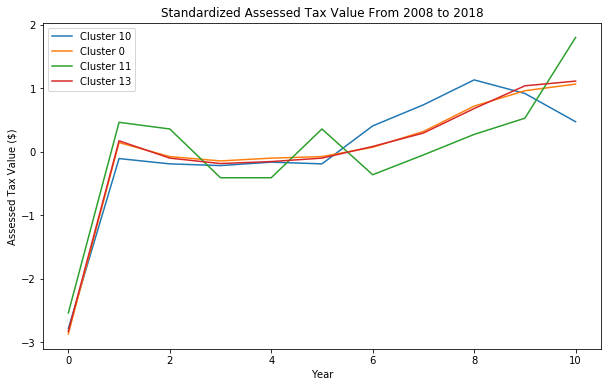

In [624]:
plt.figure(figsize = (10,6))
plt.plot(c_10_median_ss, label = 'Cluster 10')
plt.plot(c_0_median_ss, label = 'Cluster 0')
plt.plot(c_11_median_ss, label = 'Cluster 11')
plt.plot(c_13_median_ss, label = 'Cluster 13')
plt.xlabel('Year')
plt.ylabel('Assessed Tax Value ($)')
plt.title('Standardized Assessed Tax Value From 2008 to 2018')
plt.legend();

It looks like cluster 11 is the highest grower. Let's do some time series analysis on that.

In [191]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import AR, ARIMA, ARMA

In [407]:
cluster_11_df = pd.DataFrame(c_11_median_ss)
cluster_11_df['Date'] = [2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]
cluster_11_df.rename({0:'AV_TOTAL_MEAN'}, axis = 1, inplace = True)
cluster_11_df.set_index('Date', inplace = True)
cluster_11_df.head()

AV_TOTAL_MEAN
Date               
2008      -2.542469
2009       0.462790
2010       0.357862
2011      -0.410873
2012      -0.410873

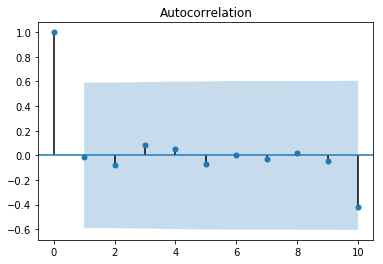

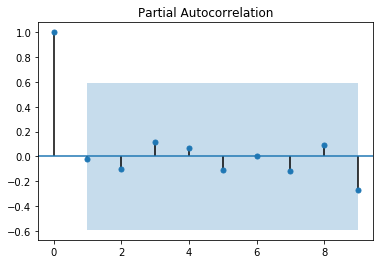

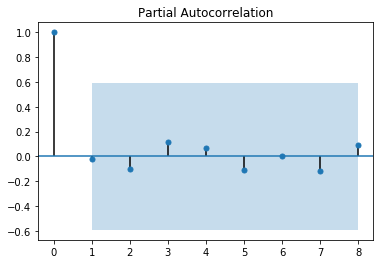

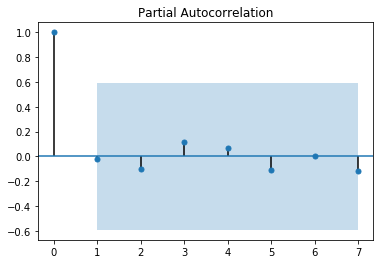

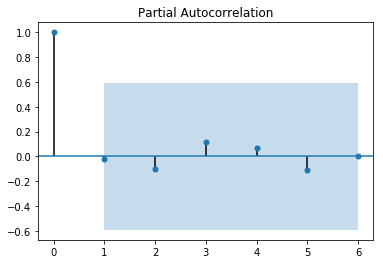

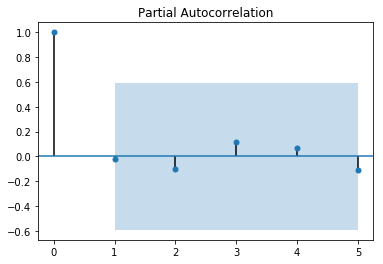

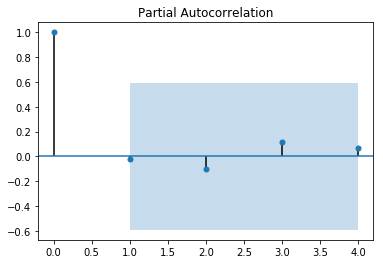

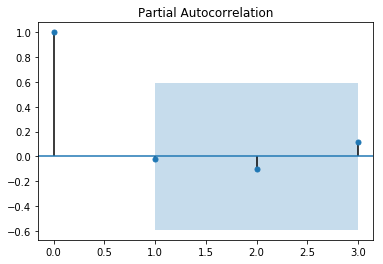

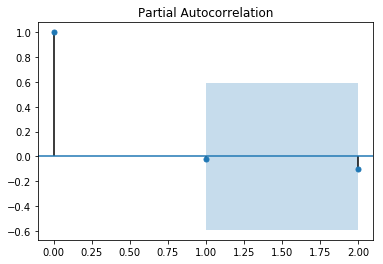

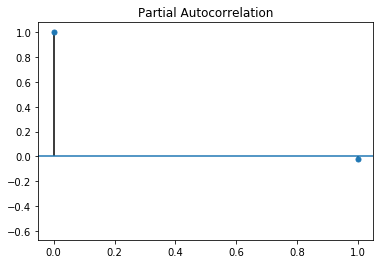

In [408]:
plot_acf(cluster_11_df, lags = 10)
plot_pacf(cluster_11_df, lags = 9)
plot_pacf(cluster_11_df, lags = 8)
plot_pacf(cluster_11_df, lags = 7)
plot_pacf(cluster_11_df, lags = 6)
plot_pacf(cluster_11_df, lags = 5)
plot_pacf(cluster_11_df, lags = 4)
plot_pacf(cluster_11_df, lags = 3)
plot_pacf(cluster_11_df, lags = 2)
plot_pacf(cluster_11_df, lags = 1)

plt.show()

What we see is that there is no significant correlation between any of the previous prices with the current price.

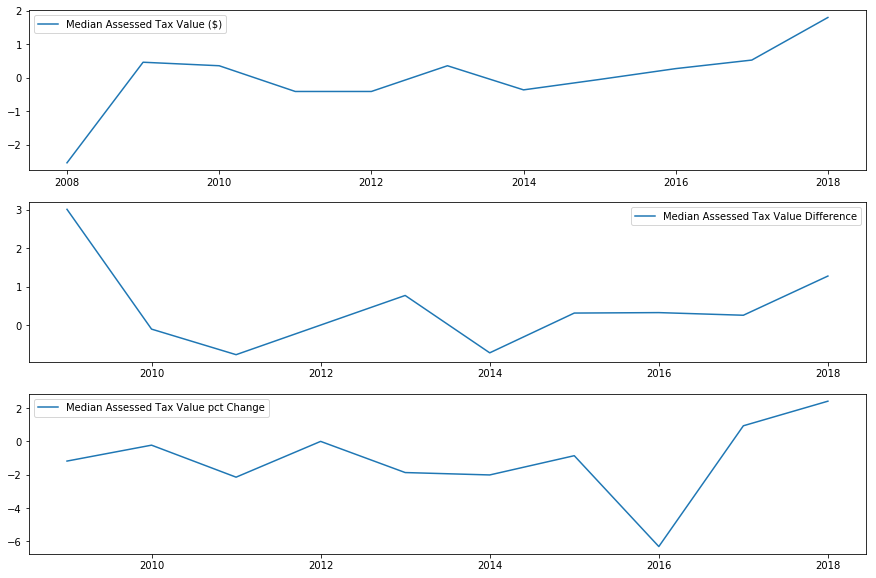

In [409]:
fig, axes = plt.subplots(ncols = 1, nrows = 3, figsize = (15,10))

axes[0].plot(cluster_11_df['AV_TOTAL_MEAN'], label = 'Median Assessed Tax Value ($)')
axes[1].plot(cluster_11_df['AV_TOTAL_MEAN'].diff(), label = 'Median Assessed Tax Value Difference')
axes[2].plot(cluster_11_df['AV_TOTAL_MEAN'].pct_change(), label = 'Median Assessed Tax Value pct Change')
axes[0].legend()
axes[1].legend()
axes[2].legend();

In [243]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor

Create a rolling mean for the regression

In [255]:
data = pd.concat([
    cluster_11_df[['AV_TOTAL_MEAN']].rename(columns={'AV_TOTAL_MEAN':'AV_TOTAL_MEAN_2_YR_RM'}).rolling(1).mean().shift(),
    cluster_11_df[['AV_TOTAL_MEAN']]
], axis = 1) #we cant use this as our X and y because the X contains our target but the shift method lags the data
             #and now we don't have our target in the same rows
data.dropna(inplace=True) #must drop the NaN values

In [256]:
X = data[['AV_TOTAL_MEAN_2_YR_RM']]
y = data['AV_TOTAL_MEAN']

In [257]:
rf = RandomForestRegressor()
cross_val_score(rf, X, y).mean()

-1.0532628469085514

In [393]:
rf.fit(X,y)
preds = rf.predict(X)

In [397]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>

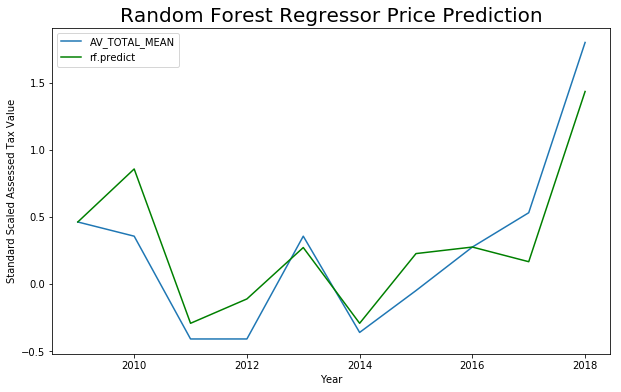

In [410]:
plt.figure(figsize=(10,6))
plt.title('Random Forest Regressor Price Prediction', fontsize=20)
plt.xlabel('Year')
plt.ylabel('Standard Scaled Assessed Tax Value')
plt.plot(y)
plt.plot(y.index, preds, color = 'green', label = 'rf.predict')
plt.legend();

In [413]:
y.std()

0.6567831507386008

In [415]:
y.mean() + y.std()

0.9111580179246794

Although the Random Forest model works pretty well, it is difficult to say what the median Standard Scaled Assessed Tax value of properties in the cluster might be. I'm sure there is a way to better analyze this time series data, but it does not look like a linear relationship and for that reason I would not suggest using the Facebook Prophet model, which suggests a linear relationship over time. Given the limited data points I believe the most robust model here is to take the mean of the median standard scaled assessed tax valueover the years, $0.25437486718607866$, and then take the standard deviation too, $0.6567831507386008$, and we can therefore say that 2019 is likely have a median standard scaled assessed tax value in the interval $(-0.4024082835525222, 0.9111580179246794)$.

Let's use Facebook Prophet for another try

In [304]:
from fbprophet import Prophet

In [331]:
cluster_11_df.drop(['index','ds'], axis = 1, inplace = True)

In [332]:
Date = ['2008-01-01','2008-01-02','2008-01-03','2008-01-04','2008-01-05','2008-01-06',
        '2008-01-07','2008-01-08','2008-01-09','2008-01-10','2008-01-11']

In [333]:
cluster_11_df['Date'] = Date

In [334]:
cluster_11_df

y        Date
0  -2.543749  2008-01-01
1   0.461318  2008-01-02
2   0.355530  2008-01-03
3  -0.410535  2008-01-04
4  -0.410423  2008-01-05
5   0.355530  2008-01-06
6  -0.361714  2008-01-07
7  -0.049846  2008-01-08
8   0.274507  2008-01-09
9   0.530242  2008-01-10
10  1.799141  2008-01-11

In [335]:
cluster_11_df.reset_index(inplace=True)
cluster_11_df.rename({'Date':'ds','AV_TOTAL_MEAN':'y'}, axis = 1, inplace = True)

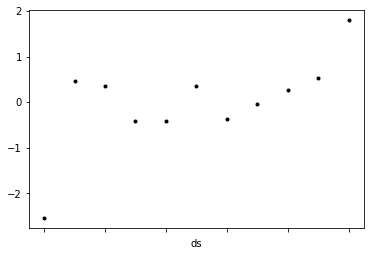

In [336]:
cluster_11_df.set_index('ds').y.plot(style = "k.");

In [337]:
#We fit the model by instantiating a new Prophet object.
model = Prophet()
model.fit(cluster_11_df)

#Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made
future = model.make_future_dataframe(periods=4)
future.tail()

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 7.0.
/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)


ds
10 2008-01-11
11 2008-01-12
12 2008-01-13
13 2008-01-14
14 2008-01-15

In [338]:
#The predict method will assign each row in future a predicted value which it names yhat.
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
10 2008-01-11  2.048664    0.792089    3.357979
11 2008-01-12  2.474798    1.234658    3.683966
12 2008-01-13  2.900931    1.691291    4.161625
13 2008-01-14  3.327065    2.159530    4.591054
14 2008-01-15  3.753198    2.434170    4.961038

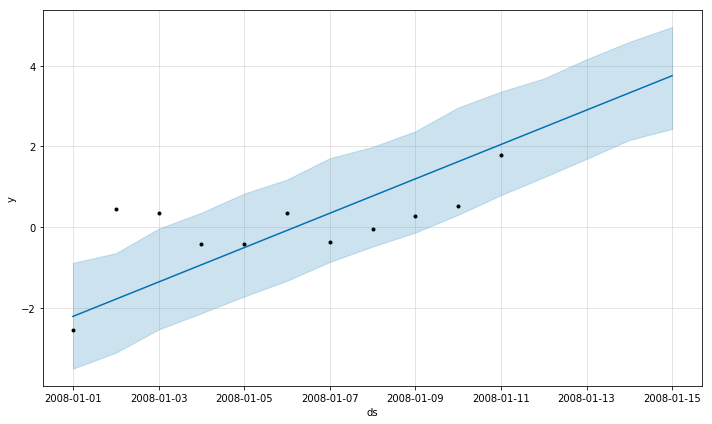

In [339]:
fig1 = model.plot(forecast)

What makes the clusters different?

In [322]:
cluster_11.describe().T

count         mean          std     min          25%  \
LAND_SF            21874.0  3942.367132  1675.897678     0.0  2702.250000   
GROSS_AREA         21874.0  5589.025236  1808.899635  2848.0  4515.000000   
LIVING_AREA        21874.0  3713.833457  1506.357146  1152.0  2852.000000   
NUM_FLOORS         21874.0     2.559584     0.710850     0.0     2.000000   
R_TOTAL_RMS        21874.0    12.886120     2.959818     1.0    10.068780   
R_BDRMS            21874.0     4.941529     2.994549     0.0     4.000000   
R_FULL_BTH         21874.0     2.075798     1.210115     0.0     2.000000   
R_HALF_BTH         21874.0     0.129743     0.419749     0.0     0.000000   
R_KITCH            21874.0     2.319647     0.634390     0.0     1.769613   
R_FPLACE           21874.0     0.133400     0.517191     0.0     0.000000   
S_NUM_BLDG         21874.0     0.000320     0.017886     0.0     0.000000   
S_UNIT_RES         21874.0     0.000869     0.049217     0.0     0.000000   
S_UNIT_COM         21874.0     0.000000     0.000000     0.0     0.000000   
S_UNIT_RC          21874.0     0.000000     0.000000     0.0     0.000000   
U_BASE_FLOOR       21874.0     0.234445     0.899453     0.0     0.000000   
U_NUM_PARK         21874.0     0.232172     1.033953     0.0     0.000000   
U_TOT_RMS          21874.0     2.593863    10.811710     0.0     0.000000   
U_BDRMS            21874.0     1.912518     8.437484     0.0     0.000000   
U_FULL_BTH         21874.0     0.173324     0.562968     0.0     0.000000   
U_HALF_BTH         21874.0     0.005809     0.084211     0.0     0.000000   
U_FPLACE           21874.0     0.002789     0.060790     0.0     0.000000   
PTYPE              21874.0   134.190363   147.315303    13.0   104.000000   
YR_BUILT           21874.0  1910.453644    20.453351  1800.0  1900.000000   
YR_REMOD           21874.0  1997.954649   172.423513  1900.0  1999.000000   
ZIPCODE            21874.0  2126.191323    33.926393     0.0  2122.000000   
LU_A               21874.0     0.038539     0.192498     0.0     0.000000   
LU_AH              21874.0     0.000000     0.000000     0.0     0.000000   
LU_C               21874.0     0.032321     0.176857     0.0     0.000000   
LU_CC              21874.0     0.000046     0.006761     0.0     0.000000   
LU_CD              21874.0     0.003612     0.059989     0.0     0.000000   
...                    ...          ...          ...     ...          ...   
U_ORIENT_A         21874.0     0.000046     0.006761     0.0     0.000000   
U_ORIENT_B         21874.0     0.000000     0.000000     0.0     0.000000   
U_ORIENT_C         21874.0     0.000640     0.025291     0.0     0.000000   
U_ORIENT_E         21874.0     0.000000     0.000000     0.0     0.000000   
U_ORIENT_F         21874.0     0.022172     0.147247     0.0     0.000000   
U_ORIENT_M         21874.0     0.000000     0.000000     0.0     0.000000   
U_ORIENT_T         21874.0     0.085810     0.280089     0.0     0.000000   
U_HEAT_TYP_0       21874.0     0.891332     0.311229     0.0     1.000000   
U_HEAT_TYP_E       21874.0     0.000000     0.000000     0.0     0.000000   
U_HEAT_TYP_F       21874.0     0.023087     0.150183     0.0     0.000000   
U_HEAT_TYP_N       21874.0     0.000000     0.000000     0.0     0.000000   
U_HEAT_TYP_O       21874.0     0.000000     0.000000     0.0     0.000000   
U_HEAT_TYP_P       21874.0     0.000549     0.023416     0.0     0.000000   
U_HEAT_TYP_S       21874.0     0.000000     0.000000     0.0     0.000000   
U_HEAT_TYP_W       21874.0     0.085032     0.278936     0.0     0.000000   
U_AC_N             21874.0     0.975405     0.154892     0.0     1.000000   
U_AC_Y             21874.0     0.024595     0.154892     0.0     0.000000   
U_KITCH_TYPE_0     21874.0     0.891332     0.311229     0.0     1.000000   
U_KITCH_TYPE_F     21874.0     0.086358     0.280899     0.0     0.000000   
U_KITCH_TYPE_N     21874.0     0.000000     0.000000     0.0     0.000000   
U_KITCH_TYPE_O   

# One thing we could do is look at the price change and run a regression on that predicted price change. That way we'll be targeting the price change and using a feature matrix that describes the change in certain variables
* First we'll look at when the price change is positive and take the log transform of that target variable
* Time provided we'll also look at the properties where the price decreased.

In [432]:
train_df = train_2008
test_df = test_2008
#Filter the DataFrame for the outliers, we'll take the 95% percentile to train our model on.        
train_df_ = train_df[train_df['AV_TOTAL']<np.percentile(train_df['AV_TOTAL'], 95)]

#depending on what you're trying to predict at you may want to use one of these instead!
#train_df_ = train_df[train_df['GROSS_TAX']<np.percentile(train_df['GROSS_TAX'], 95)]
#train_df_ = train_df[train_df['AV_LAND']<np.percentile(train_df['AV_LAND'], 95)]
#train_df_ = train_df[train_df['AV_BLDG']<np.percentile(train_df['AV_BLDG'], 95)]

#Make the target into a log transform
train_df_.AV_TOTAL = np.log(train_df_.AV_TOTAL)

#depending on what you're predicting you might want to add in the log transofrm of one of these too!
#train_df_.GROSS_TAX = np.log(train_df_.GROSS_TAX)
#train_df_.AV_LAND = np.log(train_df_.AV_LAND)
#train_df_.AV_BLDG = np.log(train_df_.AV_BLDG)


#Re-assinging the dataframe to another variable for naming purposes.
df_train = train_df_
df_test = test_df


#Feature Engineering on Training Set
#we'll take features that are either categorical and dummie them or numerical and eventually scale them.
categorical_features = df_train.select_dtypes(include = ['object']).columns
df_train_categorical = df_train[categorical_features]
df_train_categorical['PTYPE'] = df_train['PTYPE']
df_train_categorical['YR_BUILT'] = df_train['YR_BUILT']
df_train_categorical['YR_REMOD'] = df_train['YR_REMOD']
df_train_categorical['ZIPCODE'] = df_train['ZIPCODE']
categoricals_to_drop = ['PID','OWNER','ST_NUM','ST_NAME','ST_NAME_SUF','UNIT_NUM',
                        'MAIL_ADDRESS','MAIL CS','MAIL_ZIPCODE', 'LatLong', 'GIS_ID']
df_train_categorical.drop(categoricals_to_drop, axis = 1, inplace=True) #dropping the categorical variables that we don't need
df_train_dummied = pd.get_dummies(df_train_categorical) #dummie-ing the categorical variables

numeric_features = df_train.select_dtypes(include = ['float64', 'int64']).columns #selecting the 'numeric' features
df_train_numeric = df_train[numeric_features]
numeric_drop_list = ['ZIPCODE','GROSS_TAX','AV_TOTAL','AV_LAND', 'AV_BLDG','PTYPE','YR_REMOD','YR_BUILT'] #None of these are actually 'numerical' features
df_train_numeric.drop(numeric_drop_list, axis = 1, inplace = True)


#Feature Engineering on Testing Set
# Here we'll take the exact same approach to the testing dataframe.
#take the categorical variables, add in the other true categorical variables like zip code and ptype
#drop the features we don't need
categorical_features = df_test.select_dtypes(include = ['object']).columns
df_test_categorical = df_test[categorical_features]
df_test_categorical['PTYPE'] = df_test['PTYPE']
df_test_categorical['YR_BUILT'] = df_test['YR_BUILT']
df_test_categorical['YR_REMOD'] = df_test['YR_REMOD']
df_test_categorical['ZIPCODE'] = df_test['ZIPCODE']
categoricals_to_drop = ['PID','OWNER','ST_NUM','ST_NAME','ST_NAME_SUF','UNIT_NUM',
                        'MAIL_ADDRESS','MAIL CS','LatLong', 'GIS_ID']
df_test_categorical.drop(categoricals_to_drop, axis = 1, inplace=True)
df_test_dummied = pd.get_dummies(df_test_categorical)

numeric_features = df_test.select_dtypes(include = ['float64', 'int64']).columns
df_test_numeric = df_test[numeric_features]
numeric_drop_list = ['ZIPCODE','PTYPE','YR_REMOD','YR_BUILT'] #None of these are actually 'numerical' features
df_test_numeric.drop(numeric_drop_list, axis = 1, inplace = True)

# Now, we concatenate the categorical and dummied variables back together for both training and testing dataframes
X_testing_set = pd.concat([df_test_numeric, df_test_dummied], axis = 1)
X_training_set = pd.concat([df_train_numeric, df_train_dummied], axis = 1)

#must drop columns that are not present in both engineered dataframes now
last_training_drop = []
for i in X_training_set.columns:
    if i not in X_testing_set.columns:
        last_training_drop.append(i)
X_training_set.drop(last_training_drop, axis = 1, inplace = True)

last_testing_drop = []
for i in X_testing_set.columns:
    if i not in X_training_set.columns:
        last_testing_drop.append(i)
X_testing_set.drop(last_testing_drop, axis = 1, inplace = True)


# Here we assign our feature matrix and specified target variables.
X_2008 = X_training_set
y_total = df_train['AV_TOTAL']
y_tax = df_train['GROSS_TAX']
y_land = df_train['AV_LAND']
y_bldg = df_train['AV_BLDG']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_2008,
                                                    y_total,
                                                    train_size = 0.85,
                                                    random_state = 42)

#Scale Data
ss = StandardScaler()
ss.fit(X_training_set)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [433]:
X_2008['AV_TOTAL'] = train_2008['AV_TOTAL']

In [434]:
train_df = train_2018
test_df = test_2018
#Filter the DataFrame for the outliers, we'll take the 95% percentile to train our model on.        
train_df_ = train_df[train_df['AV_TOTAL']<np.percentile(train_df['AV_TOTAL'], 95)]

#depending on what you're trying to predict at you may want to use one of these instead!
#train_df_ = train_df[train_df['GROSS_TAX']<np.percentile(train_df['GROSS_TAX'], 95)]
#train_df_ = train_df[train_df['AV_LAND']<np.percentile(train_df['AV_LAND'], 95)]
#train_df_ = train_df[train_df['AV_BLDG']<np.percentile(train_df['AV_BLDG'], 95)]

#Make the target into a log transform
train_df_.AV_TOTAL = np.log(train_df_.AV_TOTAL)

#depending on what you're predicting you might want to add in the log transofrm of one of these too!
#train_df_.GROSS_TAX = np.log(train_df_.GROSS_TAX)
#train_df_.AV_LAND = np.log(train_df_.AV_LAND)
#train_df_.AV_BLDG = np.log(train_df_.AV_BLDG)


#Re-assinging the dataframe to another variable for naming purposes.
df_train = train_df_
df_test = test_df


#Feature Engineering on Training Set
#we'll take features that are either categorical and dummie them or numerical and eventually scale them.
categorical_features = df_train.select_dtypes(include = ['object']).columns
df_train_categorical = df_train[categorical_features]
df_train_categorical['PTYPE'] = df_train['PTYPE']
df_train_categorical['YR_BUILT'] = df_train['YR_BUILT']
df_train_categorical['YR_REMOD'] = df_train['YR_REMOD']
df_train_categorical['ZIPCODE'] = df_train['ZIPCODE']
categoricals_to_drop = ['PID','OWNER','ST_NUM','ST_NAME','ST_NAME_SUF','UNIT_NUM',
                        'MAIL_ADDRESS','MAIL CS','MAIL_ZIPCODE', 'LatLong', 'GIS_ID']
df_train_categorical.drop(categoricals_to_drop, axis = 1, inplace=True) #dropping the categorical variables that we don't need
df_train_dummied = pd.get_dummies(df_train_categorical) #dummie-ing the categorical variables

numeric_features = df_train.select_dtypes(include = ['float64', 'int64']).columns #selecting the 'numeric' features
df_train_numeric = df_train[numeric_features]
numeric_drop_list = ['ZIPCODE','GROSS_TAX','AV_TOTAL','AV_LAND', 'AV_BLDG','PTYPE','YR_REMOD','YR_BUILT'] #None of these are actually 'numerical' features
df_train_numeric.drop(numeric_drop_list, axis = 1, inplace = True)


#Feature Engineering on Testing Set
# Here we'll take the exact same approach to the testing dataframe.
#take the categorical variables, add in the other true categorical variables like zip code and ptype
#drop the features we don't need
categorical_features = df_test.select_dtypes(include = ['object']).columns
df_test_categorical = df_test[categorical_features]
df_test_categorical['PTYPE'] = df_test['PTYPE']
df_test_categorical['YR_BUILT'] = df_test['YR_BUILT']
df_test_categorical['YR_REMOD'] = df_test['YR_REMOD']
df_test_categorical['ZIPCODE'] = df_test['ZIPCODE']
categoricals_to_drop = ['PID','OWNER','ST_NUM','ST_NAME','ST_NAME_SUF','UNIT_NUM',
                        'MAIL_ADDRESS','MAIL CS','LatLong', 'GIS_ID']
df_test_categorical.drop(categoricals_to_drop, axis = 1, inplace=True)
df_test_dummied = pd.get_dummies(df_test_categorical)

numeric_features = df_test.select_dtypes(include = ['float64', 'int64']).columns
df_test_numeric = df_test[numeric_features]
numeric_drop_list = ['ZIPCODE','PTYPE','YR_REMOD','YR_BUILT'] #None of these are actually 'numerical' features
df_test_numeric.drop(numeric_drop_list, axis = 1, inplace = True)

# Now, we concatenate the categorical and dummied variables back together for both training and testing dataframes
X_testing_set = pd.concat([df_test_numeric, df_test_dummied], axis = 1)
X_training_set = pd.concat([df_train_numeric, df_train_dummied], axis = 1)

#must drop columns that are not present in both engineered dataframes now
last_training_drop = []
for i in X_training_set.columns:
    if i not in X_testing_set.columns:
        last_training_drop.append(i)
X_training_set.drop(last_training_drop, axis = 1, inplace = True)

last_testing_drop = []
for i in X_testing_set.columns:
    if i not in X_training_set.columns:
        last_testing_drop.append(i)
X_testing_set.drop(last_testing_drop, axis = 1, inplace = True)


# Here we assign our feature matrix and specified target variables.
X_2018 = X_training_set
y_total = df_train['AV_TOTAL']
y_tax = df_train['GROSS_TAX']
y_land = df_train['AV_LAND']
y_bldg = df_train['AV_BLDG']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_2018,
                                                    y_total,
                                                    train_size = 0.85,
                                                    random_state = 42)

#Scale Data
ss = StandardScaler()
ss.fit(X_training_set)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [435]:
X_2018['AV_TOTAL'] = train_2018['AV_TOTAL']

In [490]:
X_2018['PID']= train_2018['PID'] #slap back on the columns
X_2008['PID'] = train_2008['PID'] #slap back on the columns

In [503]:
merged = pd.merge(X_2008, X_2018, on='PID', how='inner')

In [504]:
PID_list = list(merged.PID)

In [505]:
#filter on the list
train__2008 = X_2008[X_2008.PID.isin(PID_list)]
train__2018 = X_2018[X_2018.PID.isin(PID_list)]

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [506]:
len(train__2008), len(train__2018)

(83062, 83514)

In [507]:
drop_pid_list = []
for i in list(train__2018.PID):
    if i not in list(train__2008.PID):
        drop_pid_list.append(i)

In [508]:
drop_pid_list

[]

In [510]:
#that is weird.
#this probably means there are some duplicates. We'll need to drop these.

In [514]:
train__2008.drop_duplicates(subset = 'PID', inplace = True)
train__2018.drop_duplicates(subset = 'PID', inplace = True)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [515]:
len(train__2008), len(train__2018)

(83062, 83062)

In [536]:
#train__2008.drop('PID', axis = 1, inplace = True)
train__2018.drop('PID ', axis = 1, inplace = True)

In [538]:
X_diff = train__2018.subtract(train__2008, fill_value=0) 

In [594]:
X_diff_final = X_diff#.iloc[0:83062] #I'm cutting off the dataframe here.

In [595]:
#lets filter again for where the difference of AV_TOTAL is positive so we can take the log transform of it.
#X_diff_final = X_diff_final[X_diff_final.AV_TOTAL > 0]

In [596]:
#drop any Nan values
X_diff_final.dropna(axis = 0, inplace = True)

In [597]:
len(X_diff_final)

52974

In [553]:
features = []
for i in X_diff_final.columns:
    if i != 'AV_TOTAL':
        features.append(i)

In [599]:
feature_matrix = X_diff_final[features]
y_av_change = X_diff_final['AV_TOTAL']

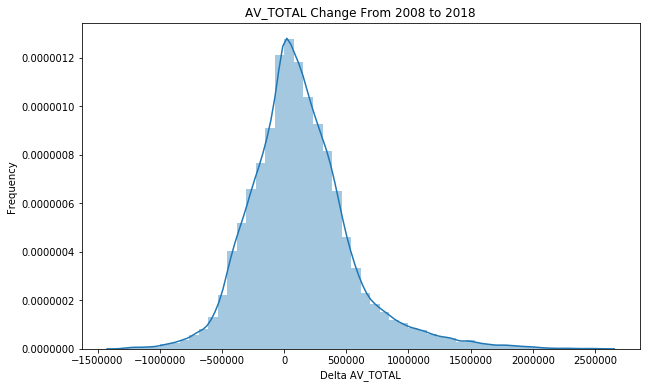

In [631]:
plt.figure(figsize=(10,6))
plt.title('AV_TOTAL Change From 2008 to 2018')
plt.ylabel('Frequency')
sns.distplot(y_av_change)
plt.xlabel('Delta AV_TOTAL');

In [648]:
y_av_change_not_0 = []
for i in list(y_av_change):
    if i != 0:
        y_av_change_not_0.append(i)
    elif i == 0:
        y_av_change_not_0.append(1)

In [649]:
#How about we take the square of the varibale the the log transform.
y_av_change_square = []
for i in list(y_av_change_not_0):
    a = i ** 2
    y_av_change_square.append(a)
    


In [650]:
y_av_change_square_log = np.log(y_av_change_square)

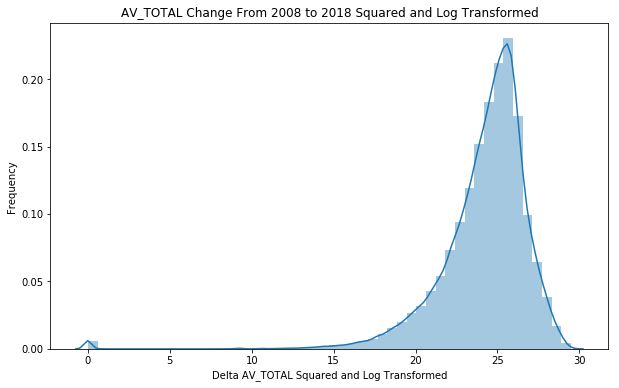

In [652]:
plt.figure(figsize=(10,6))
plt.title('AV_TOTAL Change From 2008 to 2018 Squared and Log Transformed')
plt.ylabel('Frequency')
sns.distplot(y_av_change_square_log)
plt.xlabel('Delta AV_TOTAL Squared and Log Transformed');

In [656]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(feature_matrix,
                                                    y_av_change,
                                                    #y_av_change_square_log,
                                                    train_size = 0.85,
                                                    random_state = 42)

#Scale Data
ss = StandardScaler()
ss.fit(X_diff_final[features])
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [657]:
def gsoptimizer_(est, params):
        gs = GridSearchCV(est, param_grid = params, verbose=0, scoring = 'r2')
        gs.fit(X_train_ss, y_train)
        print("Your best R^2 score is:",gs.best_score_)
#        print("Your best RMSE score is",np.sqrt(gs.best_score_*-1))
#        print("But the actual RMSE score will be something like: ", np.exp(np.sqrt(gs.best_score_*-1)))
        print("Your best alpha value is:",gs.best_params_)
#        print("Your parameters are", gs.coef_)
        y_pred = gs.predict(X_test_ss)
        
#        y_pred_df = pd.DataFrame(y_pred)
#        display(y_pred_df)
#        display(y_test)
#        print(len(y_pred_df))
#        print(len(y_test))

        x = np.linspace(min(y_pred), max(y_pred), 1000)
        plt.figure(figsize=(8,8))
        plt.title('Delta-AV_TOTAL, True Target vs Predicted Target')
        plt.scatter(y_pred,y_test, color = 'r')
        plt.plot(x,x, color = 'black')
        plt.xlabel('Predicted Value Change')
        plt.ylabel('True Value Change')
        plt.xlim(min(y_pred),max(y_pred))
        
        return gs.best_estimator_, gs.best_score_, y_pred

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

Your best R^2 score is: 0.5302342841803038
Your best alpha value is: {'alpha': 10}


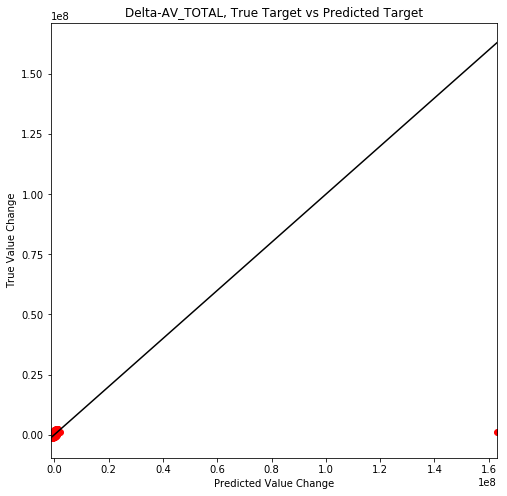

In [671]:
ridgeParams = {'alpha':[0.01, 0.1, 1, 10]}#, 100, 1000, 4250, 10000]}
bestRidgeEst = gsoptimizer_(Lasso(), ridgeParams)

In [13]:
train_dfs = [train_2008,train_2009,train_2010,train_2011,train_2012,
            train_2013,train_2014,train_2015,train_2016,train_2017,train_2018]

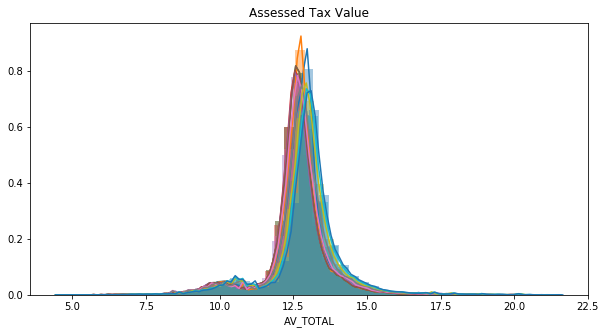

In [25]:
plt.figure(figsize=(10,5))
for i in train_dfs:
    sns.distplot(np.log(i[i['AV_TOTAL']>0]['AV_TOTAL']))
    plt.title('Assessed Tax Value');

In [28]:
np.log(train_2008[train_2008['AV_TOTAL']>0]['AV_TOTAL']).mean()

12.668303854309872

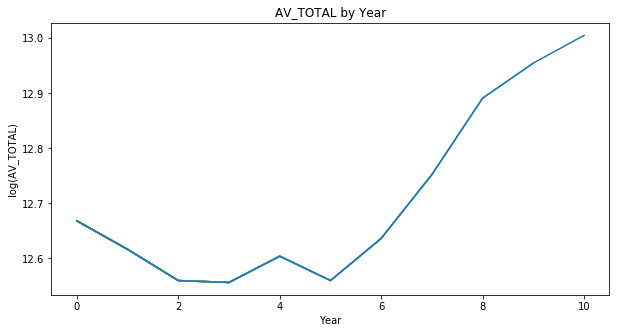

In [33]:
av_total_log_mean = []
plt.figure(figsize = (10,5))
for i in train_dfs:
    av_mean = np.log(i[i['AV_TOTAL']>0]['AV_TOTAL']).mean()
    av_total_log_mean.append(av_mean)
    plt.plot(av_total_log_mean)
    plt.title('AV_TOTAL by Year')
    plt.ylabel('log(AV_TOTAL)')
    plt.xlabel('Year')
    

In [34]:
r2_socres = [0.8223195236570878,0.7978881610736631,0.8241968142997287,
0.8323281736292755, 0.6567208216689282,0.8241968142997287,
0.7472449485865538,0.6228771307522735,0.6125715767636989,
0.5906630700632418, 0.5577937510877418]

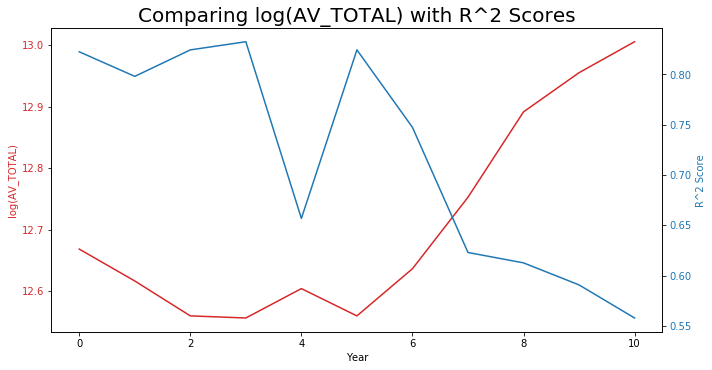

In [54]:
data1 = av_total_log_mean
data2 = r2_socres

fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('log(AV_TOTAL)', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R^2 Score', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Comparing log(AV_TOTAL) with R^2 Scores', fontsize=20)
plt.show();

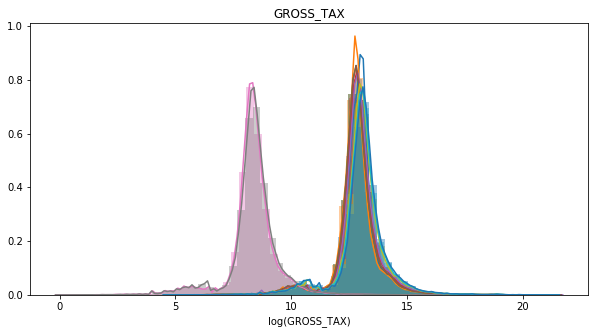

In [63]:
plt.figure(figsize=(10,5))
for i in train_dfs:
    sns.distplot(np.log(i[i['GROSS_TAX']>0]['GROSS_TAX']))
    plt.title('GROSS_TAX')
    plt.xlabel('log(GROSS_TAX)')

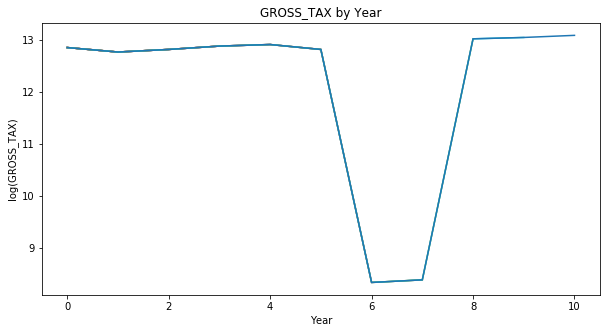

In [66]:
gross_log_mean = []
plt.figure(figsize = (10,5))
for i in train_dfs:
    gross_mean = np.log(i[i['GROSS_TAX']>0]['GROSS_TAX']).mean()
    gross_log_mean.append(gross_mean)
    plt.plot(gross_log_mean)
    plt.title('GROSS_TAX by Year')
    plt.ylabel('log(GROSS_TAX)')
    plt.xlabel('Year')
    

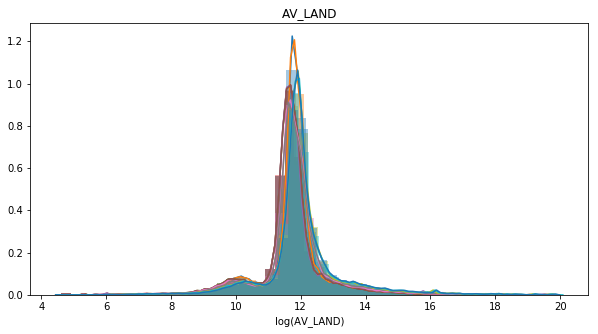

In [68]:
plt.figure(figsize=(10,5))
for i in train_dfs:
    sns.distplot(np.log(i[i['AV_LAND']>0]['AV_LAND']))
    plt.title('AV_LAND')
    plt.xlabel('log(AV_LAND)')

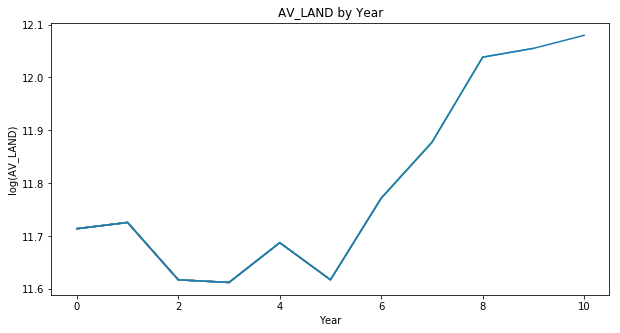

In [71]:
av_land_log_mean = []
plt.figure(figsize = (10,5))
for i in train_dfs:
    av_land_mean = np.log(i[i['AV_LAND']>0]['AV_LAND']).mean()
    av_land_log_mean.append(av_land_mean)
    plt.plot(av_land_log_mean)
    plt.title('AV_LAND by Year')
    plt.ylabel('log(AV_LAND)')
    plt.xlabel('Year');

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


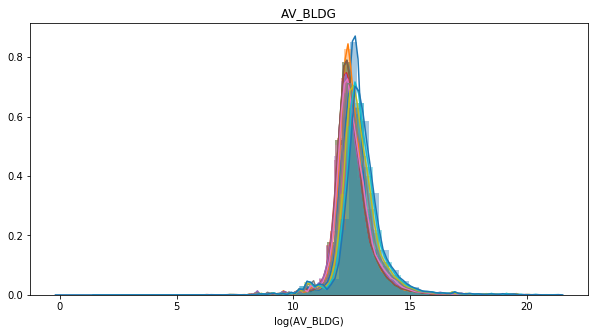

In [73]:
plt.figure(figsize=(10,5))
for i in train_dfs:
    sns.distplot(np.log(i[i['AV_BLDG']>0]['AV_BLDG']))
    plt.title('AV_BLDG')
    plt.xlabel('log(AV_BLDG)')

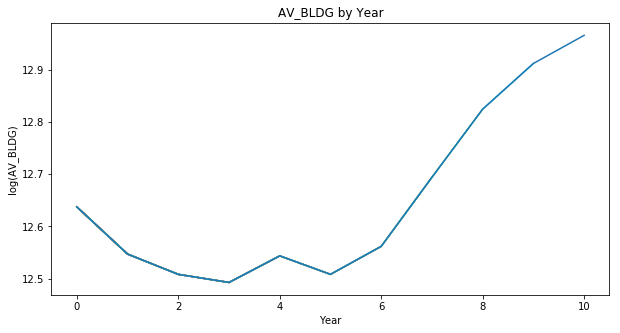

In [74]:
av_bldg_log_mean = []
plt.figure(figsize = (10,5))
for i in train_dfs:
    av_bldg_mean = np.log(i[i['AV_BLDG']>0]['AV_BLDG']).mean()
    av_bldg_log_mean.append(av_bldg_mean)
    plt.plot(av_bldg_log_mean)
    plt.title('AV_BLDG by Year')
    plt.ylabel('log(AV_BLDG)')
    plt.xlabel('Year');